The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U --pre mxnet-cu101mkl  # updating mxnet to at least v1.6
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2l


# Pretraining GloVe

:label:`sec_GloVe_gluon`


In this section, we will train a
GloVe model defined in
:numref:`sec_glove`.

First, import the
packages and
modules required for the experiment.

In [1]:
from collections import defaultdict
import d2l
from mxnet import autograd, gluon, init, np, npx, cpu
from mxnet.gluon import nn
import random

npx.set_np()

## Preprocessing Dataset
We will train GloVe model on PTB dataset. 

First, we
read the PTB dataset, build a vocabulary with words and map each token into an
index to construct the corpus.

In [2]:
sentences = d2l.read_ptb()
vocab = d2l.Vocab(sentences, min_freq=10)
corpus = [vocab[line] for line in sentences]

### Construct Cooccurrence Counts
Let the word-word cooccurrence counts be
denoted by $X$, whose entries $x_{ij}$ tabulate the number of times word $j$
occurs in the context of word $i$.

Next, we define following function to
extracts all the central target words and their context words. It use a
decreasing weighting function, so that word pairs that are $d$ words apart
contribute $1/d$ to the total count. This is one way to account for the fact
that very distant word pairs are expected to contain less relevant information
about the words’ relationship to one another.

In [3]:
def get_coocurrence_counts(corpus, window_size):
    centers, contexts = [], []
    cooccurence_counts = defaultdict(float)
    for line in corpus:
        # Each sentence needs at least 2 words to form a
        # "central target word - context word" pair
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at i
            left_indices = list(range(max(0, i - window_size), i))
            right_indices = list(range(i + 1, 
                                       min(len(line), i + 1 + window_size)))
            left_context = [line[idx] for idx in left_indices]
            right_context = [line[idx] for idx in right_indices]
            for distance, word in enumerate(left_context[::-1]):
                cooccurence_counts[line[i], word] += 1 / (distance + 1)
            for distance, word in enumerate(right_context):
                cooccurence_counts[line[i], word] += 1 / (distance + 1)
    cooccurence_counts = [(word[0], word[1], count)
                          for word, count in cooccurence_counts.items()]
    return cooccurence_counts

We create an artificial dataset containing two sentences of 5 and 2 words,
respectively. Assume the maximum context window is 4. Then, we print the
cooccurrence counts of all the central target words and context words.

In [4]:
tiny_dataset = [list(range(5)), list(range(5, 7))]
print('dataset', tiny_dataset)
for center, context, coocurrence in get_coocurrence_counts(tiny_dataset, 4):
        print('center: %s, context: %s, coocurrence: %.2f' % 
          (center, context, coocurrence))

dataset [[0, 1, 2, 3, 4], [5, 6]]
center: 0, context: 1, coocurrence: 1.00
center: 0, context: 2, coocurrence: 0.50
center: 0, context: 3, coocurrence: 0.33
center: 0, context: 4, coocurrence: 0.25
center: 1, context: 0, coocurrence: 1.00
center: 1, context: 2, coocurrence: 1.00
center: 1, context: 3, coocurrence: 0.50
center: 1, context: 4, coocurrence: 0.33
center: 2, context: 1, coocurrence: 1.00
center: 2, context: 0, coocurrence: 0.50
center: 2, context: 3, coocurrence: 1.00
center: 2, context: 4, coocurrence: 0.50
center: 3, context: 2, coocurrence: 1.00
center: 3, context: 1, coocurrence: 0.50
center: 3, context: 0, coocurrence: 0.33
center: 3, context: 4, coocurrence: 1.00
center: 4, context: 3, coocurrence: 1.00
center: 4, context: 2, coocurrence: 0.50
center: 4, context: 1, coocurrence: 0.33
center: 4, context: 0, coocurrence: 0.25
center: 5, context: 6, coocurrence: 1.00
center: 6, context: 5, coocurrence: 1.00


We set the maximum context window size to 5. The following extracts all the
central target words and their context words in the dataset, and calculate their
cooccurrence counts

In [5]:
coocurrence_matrix = get_coocurrence_counts(corpus, 5)
'# center-context pairs: %d' % len(coocurrence_matrix)

'# center-context pairs: 1630015'

### Putting All Things Together

Last, We define the load_data_ptb_glove
function that read the PTB dataset and return the data loader.

In [6]:
def load_data_ptb_glove(batch_size, window_size):
    num_workers = d2l.get_dataloader_workers()
    sentences = d2l.read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=5)
    corpus = [vocab[line] for line in sentences]
    coocurrence_matrix = get_coocurrence_counts(corpus, window_size)
    dataset = gluon.data.ArrayDataset(coocurrence_matrix)
    data_iter = gluon.data.DataLoader(dataset, batch_size, shuffle=True,
                                      num_workers=num_workers)
    return data_iter, vocab

batch_size, window_size = 1024, 10
data_iter, vocab = load_data_ptb_glove(batch_size, window_size)

Let’s print the first minibatch of the data iterator.

In [7]:
names = ['center', 'context', 'Cooccurence']
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

center shape: (1024,)
context shape: (1024,)
Cooccurence shape: (1024,)


## The GloVe Model

In section 15.1, we introduced the goal of GloVe is to
minimize the loss function.

$$\sum_{i\in\mathcal{V}} \sum_{j\in\mathcal{V}}
h(x_{ij}) \left(\mathbf{u}_j^\top \mathbf{v}_i + b_i + c_j -
\log\,x_{ij}\right)^2.$$

We will implement the GloVe model by implementing each
part of the loss function.

### Weight function

GloVe introduced a weighting
function $h(x_{ij})$ into the loss function.

$$h(x_{ij})=\begin{cases}
(\frac{x}{x_{max}})^\alpha & x_{ij}<x_{max}\\
1 & otherwise
\end{cases}$$


We
implement the weighting function $h(x_{ij})$. Since $x_{ij}<x_{max}$is
equivalent to $(\frac{x}{x_{max}})^\alpha < 1$, we can give the following
implementation.

In [8]:
def compute_weight(x, x_max = 30, alpha = 0.75):
    w = (x / x_max) ** alpha
    return np.minimum(w, 1)

The following prints the weight of the cooccurrence counts of all the central
target words and context words when the $x_{max}$ set to 2 and $\alpha$ to 0.75

In [9]:
for center, context, coocurrence in get_coocurrence_counts(tiny_dataset, 4)[:5]:
    print('center: %s, context: %s, coocurrence: %.2f, weight: %.2f' % 
          (center, context, coocurrence, compute_weight(coocurrence, x_max = 2, alpha = 0.75)))

center: 0, context: 1, coocurrence: 1.00, weight: 0.59
center: 0, context: 2, coocurrence: 0.50, weight: 0.35
center: 0, context: 3, coocurrence: 0.33, weight: 0.26
center: 0, context: 4, coocurrence: 0.25, weight: 0.21
center: 1, context: 0, coocurrence: 1.00, weight: 0.59


### Bias Term

GloVe has two scalar model parameters for each word $w_i$ : the
bias terms $b_i$ (for central target words) and  $c_i$ (for context words).
Bias term can be realized by embedding layer. The weight of the embedding layer
is a matrix whose number of rows is the dictionary size (input_dim) and whose
number of columns is one.

We set the dictionary size to  20.

In [10]:
embed_bias = nn.Embedding(input_dim=20, output_dim=1)
embed_bias.initialize()
embed_bias.weight

Parameter embedding0_weight (shape=(20, 1), dtype=float32)

The input of the embedding layer is the index of the word. When we enter the
index $i$ of a word, the embedding layer returns the $i$ th row of the weight
value as its bias term.

In [11]:
x = np.array([1, 2, 3])
embed_bias(x)

array([[0.01299825],
       [0.0301265 ],
       [0.04819721]])

### GloVe Model Forward Calculation

In forward calculation, the input of
the
GloVe model contains the central
target word index `center` and the context word
index
`context`. In which,
the `center` variable has the shape (batch
size, 1),
while the
`context` variable has the shape (batch size,
1). These
two variables
are first transformed from word indexes to word
vectors by the
word embedding
layer.

In [12]:
def GloVe(center, context, coocurrence, embed_v, embed_u,
          bias_v, bias_u, x_max, alpha):
    # Shape of v: (batch_size, embed_size)
    v = embed_v(center)
    # Shape of u: (batch_size, embed_size)
    u = embed_u(context)
    # Shape of b: (batch_size, 1)
    b = bias_v(center)
    # Shape of c: (batch_size, 1)
    c = bias_u(context)
    # Shape of embed_products: (batch_size,)
    embed_products = np.sum(v * u, axis=1)
    # Shape of distance_expr: (batch_size,)
    distance_expr = np.power(embed_products + b.reshape(-1) +
                     c.reshape(-1) - np.log(coocurrence), 2)
    # Shape of weight: (batch_size,)
    weight = compute_weight(coocurrence)
    return weight * distance_expr

Verify that the output shape should be (batch size, ).

In [13]:
embed_word = nn.Embedding(input_dim=20, output_dim=4)
embed_word.initialize()
GloVe(np.ones((2)), np.ones((2)), np.ones((2)), embed_word, embed_word,
      embed_bias, embed_bias, x_max = 2, alpha = 0.75).shape

(2,)

## Training

Before training the word embedding model, we need to define the
loss function of
the model.

### Initializing Model Parameters
We construct the
embedding layers of words and
additional biases,
and set the hyperparameter word
vector
dimension `embed_size`
to
100.

In [14]:
embed_size = 100
net = nn.Sequential()
net.add(nn.Embedding(input_dim=len(vocab), output_dim=embed_size),
        nn.Embedding(input_dim=len(vocab), output_dim=embed_size),
        nn.Embedding(input_dim=len(vocab), output_dim=1),
        nn.Embedding(input_dim=len(vocab), output_dim=1))

### Training

The training function is defined below.

In [15]:
def train(net, data_iter, lr, num_epochs, x_max, alpha, ctx=d2l.try_gpu()):
    net.initialize(ctx=ctx, force_reinit=True)
    trainer = gluon.Trainer(net.collect_params(), 'AdaGrad',
                            {'learning_rate': lr})
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # loss_sum, num_tokens
        for i, batch in enumerate(data_iter):
            center, context, coocurrence = [
                data.as_in_context(ctx) for data in batch]
            with autograd.record():
                l = GloVe(center, context, coocurrence.astype('float32'),
                          net[0], net[1], net[2], net[3], x_max, alpha)
            l.backward()
            trainer.step(batch_size)
            metric.add(l.sum(), l.size)
            if (i+1) % 50 == 0:
                animator.add(epoch+(i+1)/len(data_iter),
                             (metric[0]/metric[1],))
    print('loss %.3f, %d tokens/sec on %s ' % (
        metric[0]/metric[1], metric[1]/timer.stop(), ctx))

Now, we can train a GloVe model.

loss 0.035, 63594 tokens/sec on gpu(0) 


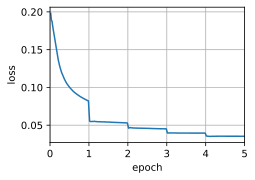

In [16]:
lr, num_epochs = 0.05, 5
x_max, alpha = 100, 0.75
train(net, data_iter, lr, num_epochs, x_max, alpha)

## Applying the GloVe Model

GloVe model generates two sets of word vectors,
`embed_v` and `embed_u` . `embed_v` and `embed_u` are
equivalent and differ only
as a result of their random initializations; the two sets of vectors should
perform equivalently.Generally, we choose to use the sum `embed_v`+`embed_u` as
our word vectors.


After training the GloVe model, we can still represent
similarity in meaning between words based on the cosine similarity of two word
vectors.

In [17]:
def get_similar_tokens(query_token, k, embed_v, embed_u):
    W = embed_v.weight.data() + embed_u.weight.data()
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = np.dot(W, x) / np.sqrt(np.sum(W * W, axis=1) * np.sum(x * x) + 1e-9)
    topk = npx.topk(cos, k=k+1, ret_typ='indices').asnumpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print('cosine sim=%.3f: %s' % (cos[i], (vocab.idx_to_token[i])))

get_similar_tokens('chip', 3, net[0], net[1])

cosine sim=0.543: population
cosine sim=0.527: microprocessor
cosine sim=0.517: giant


## Summary

* We can pretrain a GloVe model.


## Exercises



##
[Discussions](https://discuss.mxnet.io/t/2387)

![](../img/qr_word2vec-
pretraining.svg)